In [2]:
import pandas as pd

data = pd.read_csv('sms.csv')
print(data)

     label                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

data['label'] = data['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

vectorizer = CountVectorizer(stop_words='english', max_features=1000, token_pattern=r"(?u)\b[a-zA-Z]+\b")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

feature_names = vectorizer.get_feature_names_out() 


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Библиотечный встроенный метод (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vec, y_train)

# Выбор признаков с помощью SelectFromModel
rf_selector = SelectFromModel(rf, prefit=True, max_features=30)
X_train_rf = rf_selector.transform(X_train_vec)
X_test_rf = rf_selector.transform(X_test_vec)

top30_indices_rf = rf_selector.get_support(indices=True)
top30_features_rf = feature_names[top30_indices_rf]
print("Библиотечный встроенный метод (Random Forest):", top30_features_rf)

Библиотечный встроенный метод (Random Forest): ['awarded' 'cash' 'chat' 'claim' 'com' 'contact' 'customer' 'dating'
 'free' 'guaranteed' 'landline' 'mobile' 'new' 'nokia' 'po' 'prize'
 'receive' 'reply' 'ringtone' 'service' 'sms' 'stop' 'text' 'tone' 'txt'
 'uk' 'urgent' 'win' 'won' 'www']


In [5]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=42)

# Инициализация Sequential Feature Selector
sfs = SequentialFeatureSelector(logreg, n_features_to_select=30, direction='forward', scoring='accuracy', cv=5)

sfs.fit(X_train_vec, y_train)

selected_features_sfs = sfs.get_support(indices=True)

X_train_sfs = X_train_vec[:, selected_features_sfs]
X_test_sfs = X_test_vec[:, selected_features_sfs]

feature_names = vectorizer.get_feature_names_out()
top30_features_sfs_names = feature_names[selected_features_sfs]
print("Библиотечный обёрточный метод (Sequential Feature Selector):")
print(top30_features_sfs_names)

Библиотечный обёрточный метод (Sequential Feature Selector):
['ac' 'admirer' 'bid' 'cash' 'claim' 'cos' 'cost' 'download' 'good' 'gt'
 'home' 'k' 'landline' 'later' 'matches' 'mobile' 'pobox' 'private'
 'prize' 'rate' 'reveal' 'ringtone' 'service' 'sky' 'sorry' 'txt' 'uk'
 'valued' 'video' 'www']


In [6]:
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

# Фильтрующий метод с mutual_info_classif
mi_selector = SelectPercentile(mutual_info_classif, percentile=3)
mi_selector.fit(X_train_vec, y_train)

X_train_mi = mi_selector.transform(X_train_vec)
X_test_mi = mi_selector.transform(X_test_vec)

top30_indices_mi = mi_selector.get_support(indices=True)
top30_features_mi = feature_names[top30_indices_mi]
print("Библиотечный фильтрующий метод (Mutual Information):", top30_features_mi)

Библиотечный фильтрующий метод (Mutual Information): ['awarded' 'box' 'cash' 'claim' 'collection' 'com' 'contact' 'cs'
 'customer' 'draw' 'free' 'guaranteed' 'landline' 'mobile' 'nokia' 'po'
 'prize' 'reply' 'ringtone' 'service' 'stop' 'text' 'tone' 'txt' 'uk' 'ur'
 'urgent' 'win' 'won' 'www']


In [7]:
set_rf = set(top30_features_rf)
set_sfs = set(top30_features_sfs_names)
set_mi = set(top30_features_mi)

intersection = set_rf & set_sfs & set_mi
print("Общие признаки (Embedded, Wrapper, Filter):")
print(intersection)

Общие признаки (Embedded, Wrapper, Filter):
{'www', 'service', 'prize', 'uk', 'claim', 'ringtone', 'landline', 'txt', 'mobile', 'cash'}


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def evaluate_classifiers(X_tr, X_te, y_tr, y_te):
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': SVC(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        acc = accuracy_score(y_te, y_pred)
        results[name] = acc
    return results


In [9]:

results_before = evaluate_classifiers(X_train_vec, X_test_vec, y_train, y_test)
print("\nКачество классификаторов до выбора признаков:")
for clf, acc in results_before.items():
    print(f"{clf}: {acc:.4f}")

results_rf = evaluate_classifiers(X_train_rf, X_test_rf, y_train, y_test)
print("\nКачество классификаторов после встроенного метода (Random Forest):")
for clf, acc in results_rf.items():
    print(f"{clf}: {acc:.4f}")

results_sfs = evaluate_classifiers(X_train_sfs, X_test_sfs, y_train, y_test)
print("\nКачество классификаторов после обёрточного метода (Sequential Feature Selector):")
for clf, acc in results_sfs.items():
    print(f"{clf}: {acc:.4f}")

results_mi = evaluate_classifiers(X_train_mi, X_test_mi, y_train, y_test)
print("\nКачество классификаторов после фильтрующего метода (Mutual Information):")
for clf, acc in results_mi.items():
    print(f"{clf}: {acc:.4f}")


Качество классификаторов до выбора признаков:
Logistic Regression: 0.9776
SVM: 0.9758
Random Forest: 0.9740

Качество классификаторов после встроенного метода (Random Forest):
Logistic Regression: 0.9525
SVM: 0.9516
Random Forest: 0.9543

Качество классификаторов после обёрточного метода (Sequential Feature Selector):
Logistic Regression: 0.9534
SVM: 0.9525
Random Forest: 0.9552

Качество классификаторов после фильтрующего метода (Mutual Information):
Logistic Regression: 0.9471
SVM: 0.9552
Random Forest: 0.9578


In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

kmeans_before = KMeans(n_clusters=2, random_state=42)
clusters_before = kmeans_before.fit_predict(X_train_vec)

# Оценка качества кластеризации
silhouette_before = silhouette_score(X_train_vec, clusters_before)
ari_before = adjusted_rand_score(y_train, clusters_before)
nmi_before = normalized_mutual_info_score(y_train, clusters_before)

print(f"\nКачество кластеризации до выбора признаков:")
print(f"Silhouette Score: {silhouette_before:.4f}")
print(f"Adjusted Rand Index (ARI): {ari_before:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_before:.4f}")


Качество кластеризации до выбора признаков:
Silhouette Score: 0.1569
Adjusted Rand Index (ARI): 0.0203
Normalized Mutual Information (NMI): 0.0010


In [11]:

kmeans_after = KMeans(n_clusters=2, random_state=42)
clusters_after = kmeans_after.fit_predict(X_train_sfs)

silhouette_after = silhouette_score(X_train_sfs, clusters_after)
ari_after = adjusted_rand_score(y_train, clusters_after)
nmi_after = normalized_mutual_info_score(y_train, clusters_after)

print(f"\nКачество кластеризации после выбора признаков (Sequential Feature Selector):")
print(f"Silhouette Score: {silhouette_after:.4f}")
print(f"Adjusted Rand Index (ARI): {ari_after:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_after:.4f}")


Качество кластеризации после выбора признаков (Sequential Feature Selector):
Silhouette Score: 0.5834
Adjusted Rand Index (ARI): -0.0352
Normalized Mutual Information (NMI): 0.0103


In [12]:
from sklearn.decomposition import PCA

pca_before = PCA(n_components=2, random_state=42)
X_pca_before = pca_before.fit_transform(X_train_vec.toarray())

pca_after = PCA(n_components=2, random_state=42)
X_pca_after = pca_after.fit_transform(X_train_sfs.toarray())

In [13]:
from sklearn.manifold import TSNE

tsne_before = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne_before = tsne_before.fit_transform(X_train_vec.toarray())

tsne_after = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne_after = tsne_after.fit_transform(X_train_sfs.toarray())


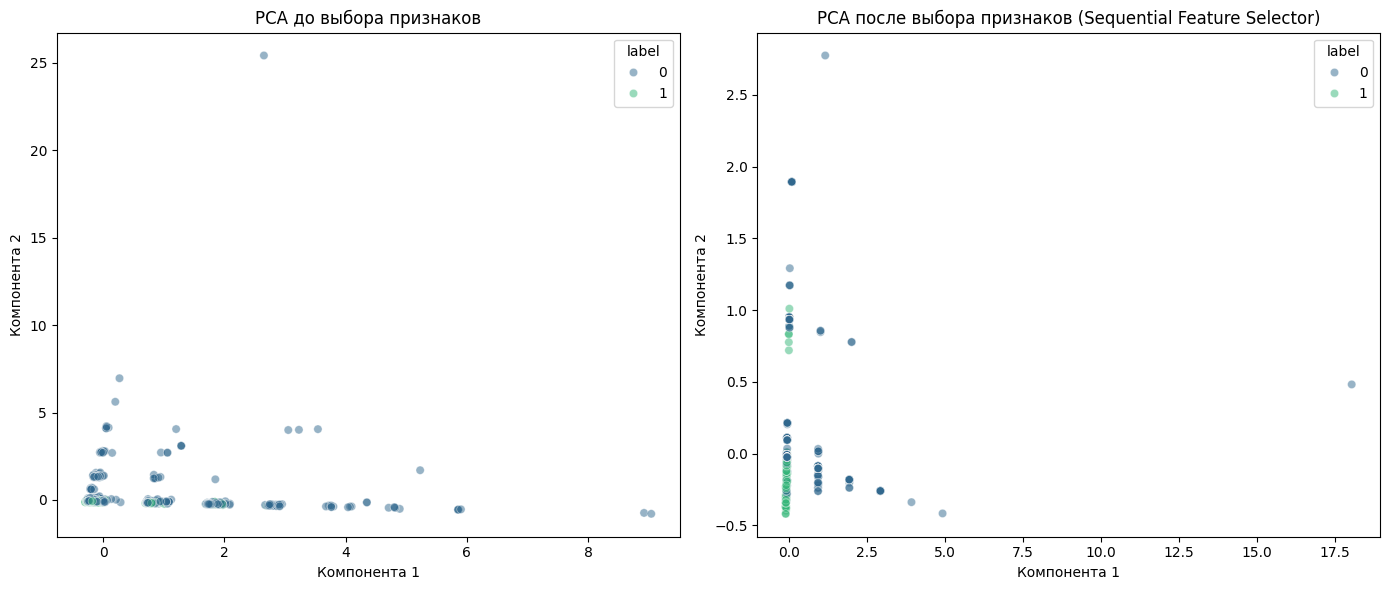

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca_before[:, 0], y=X_pca_before[:, 1], hue=y_train, palette='viridis', alpha=0.5)
plt.title('PCA до выбора признаков')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca_after[:, 0], y=X_pca_after[:, 1], hue=y_train, palette='viridis', alpha=0.5)
plt.title('PCA после выбора признаков (Sequential Feature Selector)')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')

plt.tight_layout()
plt.show()


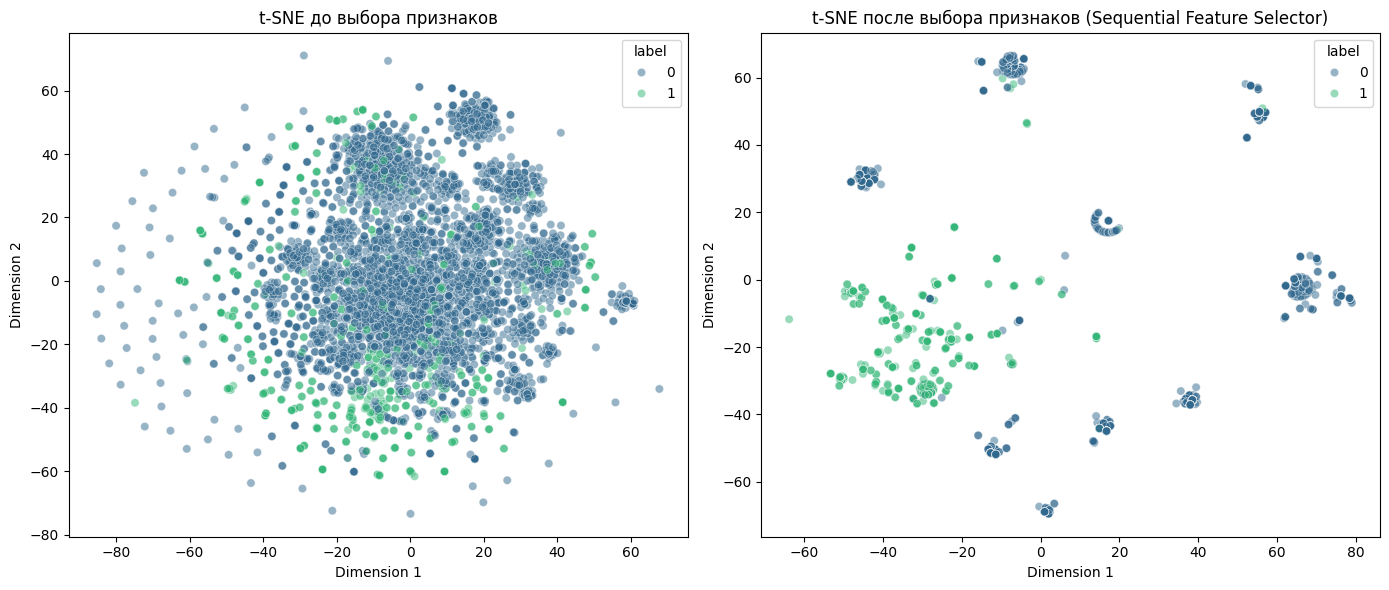

In [15]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne_before[:, 0], y=X_tsne_before[:, 1], hue=y_train, palette='viridis', alpha=0.5)
plt.title('t-SNE до выбора признаков')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne_after[:, 0], y=X_tsne_after[:, 1], hue=y_train, palette='viridis', alpha=0.5)
plt.title('t-SNE после выбора признаков (Sequential Feature Selector)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.tight_layout()
plt.show()

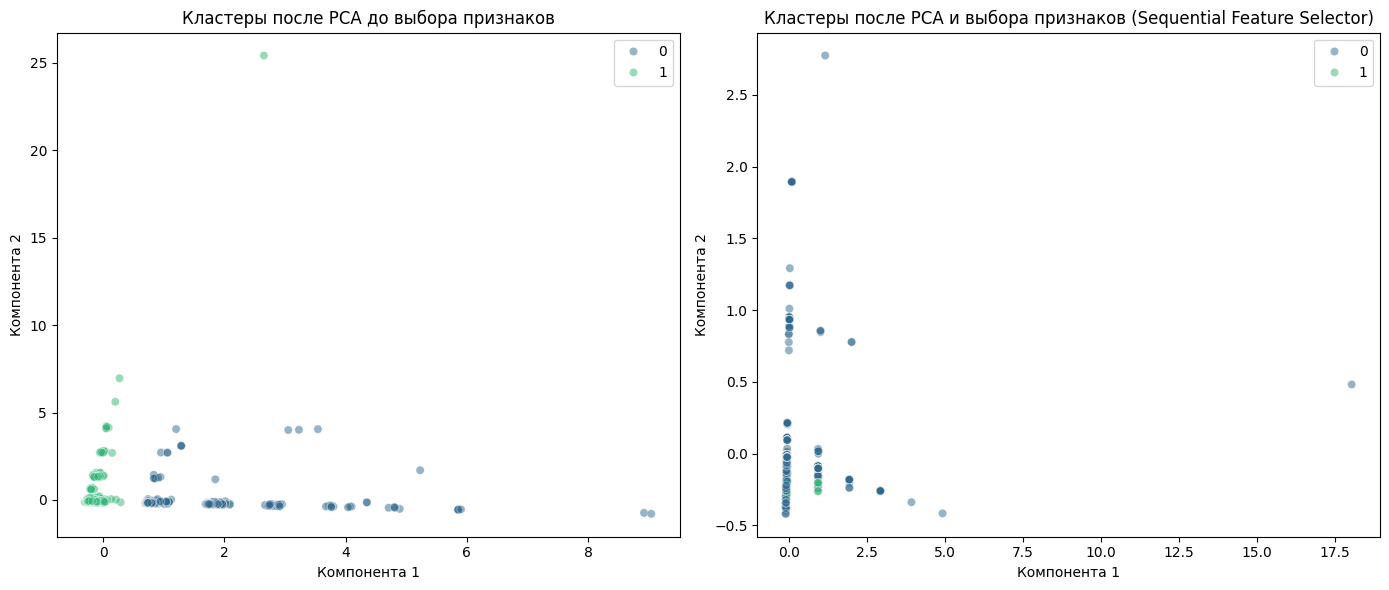

In [16]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca_before[:, 0], y=X_pca_before[:, 1], hue=clusters_before, palette='viridis', alpha=0.5)
plt.title('Кластеры после PCA до выбора признаков')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca_after[:, 0], y=X_pca_after[:, 1], hue=clusters_after, palette='viridis', alpha=0.5)
plt.title('Кластеры после PCA и выбора признаков (Sequential Feature Selector)')
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')

plt.tight_layout()
plt.show()